In [298]:
"""
project_grp16_v3.ipynb
This notebook performs data analysis on the SnackChain dataset, demonstrating
cleaning, exploratory data analysis, and modeling steps.
"""

'\nproject_grp16_v3.ipynb\nThis notebook performs data analysis on the SnackChain dataset, demonstrating\ncleaning, exploratory data analysis, and modeling steps.\n'

In [299]:
# Currently in use
import re                               # Extraction of text
import pandas as pd                     # Data manipulation
import numpy as np                      # Numeric computations
import matplotlib.pyplot as plt         # Plotting
import seaborn as sns                   # Visualizations
import statsmodels.api as sm            # Regression


### Clean 'stores.xlsx'

In [300]:
# Import the stores.xlsx file
df_stores = pd.read_excel('stores.xlsx')

In [301]:
# Convert column headers to lowercase
df_stores.columns = df_stores.columns.str.lower()
# Convert column data to lower case
df_stores = df_stores.map(lambda x: x.lower() if isinstance(x, str) else x)

### Clean 'products.xlsx'

In [302]:
# Import the products.xlsx file
df_products = pd.read_excel('products.xlsx')

In [303]:
# Convert column headers to lower case
df_products.columns = df_products.columns.str.lower()
# Convert column data to lower case
df_products = df_products.map(lambda x: x.lower() if isinstance(x, str) else x)

### Clean 'transactions.xlsx'

In [304]:
# Import the transactions.xlsx file
df_transactions = pd.read_excel('transactions.xlsx')

In [305]:
# Convert column headers to lower case
df_transactions.columns = df_transactions.columns.str.lower()
# Convert column data to lower case
df_transactions = df_transactions.map(lambda x: x.lower() if isinstance(x, str) else x)

### Remove Oral Hygiene Products

In [306]:
# Create a clean copy of the dataframe to avoid chained assignment warnings
df_prod_cln = df_products[df_products['category'] != 'oral hygiene products'].copy()

In [307]:
# Remove 'oral hygiene products' based on UPCs in df_prod_cln 
# The products df only without the oral hygiene products)
keep_upcs = df_prod_cln['upc'].unique()

# Only keep the UPCs in df_prod_cln
df_trans_cln =df_transactions[df_transactions['upc'].isin(keep_upcs)]


### Standardize Product Size

In [308]:
# Function to extract numeric value and unit using regex
def extract_size_details(size):
    """
    Extracts a numeric value and unit from a product_size string using regex.
    
    Args:
        size (str): A string representing the product size (e.g., "15 OZ", "1.5 LT").
    
    Returns:
        pd.Series: A pandas Series containing the extracted value (float) and unit (str).
    """
    if isinstance(size, str):
        match = re.match(r"(\d*\.?\d+)\s*([a-zA-Z]+)", size)  # Extract number and unit
        if match:
            return pd.Series([float(match.group(1)), match.group(2).lower()])
    return pd.Series([None, None])  # Handle missing or incorrect formats
# Apply function to extract size and unit safely
df_prod_cln[['size_value', 'size_unit']] = df_prod_cln['product_size'].apply(
    extract_size_details)
# Define conversion rates in a dictionary
conversion_rates = {"ml": 1, "oz": 29.5735, "lt": 1000}

df_prod_cln['size_in_ml'] = df_prod_cln.apply(
    lambda row: row['size_value'] * conversion_rates.get(row['size_unit'], np.nan)
    if pd.notna(row['size_value']) and pd.notna(row['size_unit']) else np.nan, axis=1
)
# Drop the original product_size column since it's no longer needed
df_prod_cln.drop(columns=['product_size'], inplace=True)
# Debug: Check conversion results
print(df_prod_cln[['size_value', 'size_unit', 'size_in_ml']].head())
# Verify if any unknown units exist
unknown_units = df_prod_cln[~df_prod_cln['size_unit'].isin(conversion_rates.keys()) &
                            df_prod_cln['size_unit'].notna()]
if not unknown_units.empty:
    print("\n Unknown Units Found:\n", unknown_units['size_unit'].unique())

   size_value size_unit  size_in_ml
0       15.00        oz  443.602500
1       15.00        oz  443.602500
2       15.00        oz  443.602500
6       12.25        oz  362.275375
7       20.00        oz  591.470000


In [309]:
# Ensure product_size is gone
df_prod_cln.head()

,upc,description,manufacturer,category,sub_category,size_value,size_unit,size_in_ml
0,1111009477,pl mini twist pretzels,private label,bag snacks,pretzels,15.00,oz,443.602500
1,1111009497,pl pretzel sticks,private label,bag snacks,pretzels,15.00,oz,443.602500
2,1111009507,pl twist pretzels,private label,bag snacks,pretzels,15.00,oz,443.602500
6,1111085319,pl honey nut toastd oats,private label,cold cereal,all family cereal,12.25,oz,362.275375
7,1111085345,pl raisin bran,private label,cold cereal,adult cereal,20.00,oz,591.470000


In [310]:
# Check missing values in all dataframes
print("Missing values in df_stores:")
print(df_stores.isnull().sum())
print('------------------------')
print("\nMissing values in df_prod_cln:")
print(df_prod_cln.isnull().sum())
print('------------------------')
print("\nMissing values in df_trans_cln:")
print(df_trans_cln.isnull().sum())

Missing values in df_stores:
store_id               0
store_name             0
city                   0
state                  0
msa                    0
segment                0
parking               52
size                   0
avg_weekly_baskets     0
dtype: int64
------------------------

Missing values in df_prod_cln:
upc             0
description     0
manufacturer    0
category        0
sub_category    0
size_value      0
size_unit       0
size_in_ml      0
dtype: int64
------------------------

Missing values in df_trans_cln:
week_end_date      0
store_num          0
upc                0
units              0
visits             0
hhs                0
spend              0
price             10
base_price       173
feature            0
display            0
tpr_only           0
dtype: int64


In [311]:
# Drop COLUMNS: 'parking', 'unnamed: 9', and 'unnamed: 10'from df_stores (Parking values = 35%)
df_stores.drop(columns=['parking'], inplace=True)

In [312]:
# Check missing values in all dataframes
print("Missing values in df_stores:")
print(df_stores.isnull().sum())
print('------------------------')
print("\nMissing values in df_prod_cln:")
print(df_prod_cln.isnull().sum())
print('------------------------')
print("\nMissing values in df_trans_cln:")
print(df_trans_cln.isnull().sum())

Missing values in df_stores:
store_id              0
store_name            0
city                  0
state                 0
msa                   0
segment               0
size                  0
avg_weekly_baskets    0
dtype: int64
------------------------

Missing values in df_prod_cln:
upc             0
description     0
manufacturer    0
category        0
sub_category    0
size_value      0
size_unit       0
size_in_ml      0
dtype: int64
------------------------

Missing values in df_trans_cln:
week_end_date      0
store_num          0
upc                0
units              0
visits             0
hhs                0
spend              0
price             10
base_price       173
feature            0
display            0
tpr_only           0
dtype: int64


In [313]:
# Drop ROWS with missing price and base_price values
df_trans_cln.dropna(subset=['price', 'base_price'], inplace=True)

/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_22577/3639009700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trans_cln.dropna(subset=['price', 'base_price'], inplace=True)


In [314]:
# Check missing values in all dataframes
print("Missing values in df_stores:")
print(df_stores.isnull().sum())
print('------------------------')
print("\nMissing values in df_prod_cln:")
print(df_prod_cln.isnull().sum())
print('------------------------')
print("\nMissing values in df_trans_cln:")
print(df_trans_cln.isnull().sum())

Missing values in df_stores:
store_id              0
store_name            0
city                  0
state                 0
msa                   0
segment               0
size                  0
avg_weekly_baskets    0
dtype: int64
------------------------

Missing values in df_prod_cln:
upc             0
description     0
manufacturer    0
category        0
sub_category    0
size_value      0
size_unit       0
size_in_ml      0
dtype: int64
------------------------

Missing values in df_trans_cln:
week_end_date    0
store_num        0
upc              0
units            0
visits           0
hhs              0
spend            0
price            0
base_price       0
feature          0
display          0
tpr_only         0
dtype: int64


### ||------------ End v2 // Begin v3 ------------||

### Merge the three tables together to get one data set

In [315]:
# 1. Merge transactions with stores on store_num -> store_id
df_merged = df_trans_cln.merge(
    df_stores,
    how='left',
    left_on='store_num', # Table B (all)
    right_on='store_id'
)

# 2. Merge the results with products on ups
df_final = df_merged.merge(
    df_prod_cln,
    how='left',
    on='upc'
)

In [316]:
df_final.head()

,week_end_date,store_num,upc,units,visits,hhs,spend,price,base_price,feature,...,segment,size,avg_weekly_baskets,description,manufacturer,category,sub_category,size_value,size_unit,size_in_ml
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,...,value,24721,12706.532051,pl mini twist pretzels,private label,bag snacks,pretzels,15.00,oz,443.602500
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,...,value,24721,12706.532051,pl pretzel sticks,private label,bag snacks,pretzels,15.00,oz,443.602500
2,2009-01-14,367,1111009507,14,14,14,19.32,1.38,1.38,0,...,value,24721,12706.532051,pl twist pretzels,private label,bag snacks,pretzels,15.00,oz,443.602500
3,2009-01-14,367,1111085319,14,13,13,26.32,1.88,1.88,0,...,value,24721,12706.532051,pl honey nut toastd oats,private label,cold cereal,all family cereal,12.25,oz,362.275375
4,2009-01-14,367,1111085345,29,26,25,54.52,1.88,1.88,0,...,value,24721,12706.532051,pl raisin bran,private label,cold cereal,adult cereal,20.00,oz,591.470000


In [317]:
# Use shape to determine if the number of columns in df_final = the updated_dictionary...they do!
num_columns = df_final.shape[1] # 1=columns, 0=rows
num_columns

27

### Merge successful ✅

In [318]:
df_merged.columns

Index(['week_end_date', 'store_num', 'upc', 'units', 'visits', 'hhs', 'spend',
       'price', 'base_price', 'feature', 'display', 'tpr_only', 'store_id',
       'store_name', 'city', 'state', 'msa', 'segment', 'size',
       'avg_weekly_baskets'],
      dtype='object')

In [319]:
df_merged.dtypes

week_end_date         datetime64[ns]
store_num                      int64
upc                            int64
units                          int64
visits                         int64
hhs                            int64
spend                        float64
price                        float64
base_price                   float64
feature                        int64
display                        int64
tpr_only                       int64
store_id                       int64
store_name                    object
city                          object
state                         object
msa                            int64
segment                       object
size                           int64
avg_weekly_baskets           float64
dtype: object

In [320]:
#Convert store_name, city, state, segment, description, manufacturer, category, and sub_category size_unit to str dtype
df_final['store_name'] = df_final['store_name'].astype('string')
df_final['city'] = df_final['city'].astype('string')
df_final['state'] = df_final['state'].astype('string')
df_final['segment'] = df_final['segment'].astype('string')
df_final['description'] = df_final['description'].astype('string')
df_final['manufacturer'] = df_final['manufacturer'].astype('string')
df_final['category'] = df_final['category'].astype('string')
df_final['sub_category'] = df_final['sub_category'].astype('string')
df_final['size_unit'] = df_final['size_unit'].astype('string')

df_final.dtypes

week_end_date         datetime64[ns]
store_num                      int64
upc                            int64
units                          int64
visits                         int64
hhs                            int64
spend                        float64
price                        float64
base_price                   float64
feature                        int64
display                        int64
tpr_only                       int64
store_id                       int64
store_name            string[python]
city                  string[python]
state                 string[python]
msa                            int64
segment               string[python]
size                           int64
avg_weekly_baskets           float64
description           string[python]
manufacturer          string[python]
category              string[python]
sub_category          string[python]
size_value                   float64
size_unit             string[python]
size_in_ml                   float64
d

In [321]:
# feature, 0=No, 1=Yes, 9%=1

### Exploratory Data Analysis

### Identify the items that have been on sale at some point

In [322]:
# 1. Create a flag for a temporary price reduction (TPR)
df_final['tpr'] = (df_final['price'] < df_final['base_price']).astype(int)

# 2. Create a single column indicating ANY promotion
df_final['on_sale'] = (
    (df_final['display'] == 1) | 
    (df_final['feature'] == 1) | 
    (df_final['tpr'] == 1)
).astype(int)

# Quick check
df_final[['display', 'feature', 'tpr', 'on_sale']].head(10)

,display,feature,tpr,on_sale
0,0,0,1,1
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,1,0,1,1
7,1,0,1,1
8,1,0,1,1
9,0,0,0,0


In [323]:
# 1. Filter rows where on_sale == 1 to find the products that have been on sale
on_sale_rows = df_final[df_final['on_sale'] == 1]

# 2. Keep only the product identifier and description, remove duplicates
products_ever_on_sale = on_sale_rows[['upc', 'description']].drop_duplicates()

# 3. Display or store the result
print(products_ever_on_sale)

                upc                description
0        1111009477     pl mini twist pretzels
6        1111087395    pl sr crust suprm pizza
7        1111087396   pl sr crust 3 meat pizza
8        1111087398   pl sr crust pepprn pizza
11       1600027564                gm cheerios
13       3000006340         qker life original
14       3000006560  qker cap n crunch berries
15       3000006610          qker cap n crunch
18       3800039118           kell froot loops
19       7027316204       shurgd mini pretzels
20       7027316404      shurgd pretzel sticks
21       7192100336        digiorno three meat
22       7192100337        digrn supreme pizza
23       7192100339           digrn pepp pizza
27       7797508004   snydr sourdough nibblers
28       7797508006     snydr ff mini pretzels
30       1111009497          pl pretzel sticks
50       7027312504        shurgd pretzel rods
54       7110410470        mksl dutch pretzels
55       7110410471        mksl pretzel sticks
74       1600

In [324]:
# Define file name
# file_name = "df_final_export.xlsx"

# # Filter for products that have been on sale at least once
# sale_products = df_final[df_final['on_sale'] == 1][['upc', 'description']].drop_duplicates()

# # Export to an Excel file with two sheets
# with pd.ExcelWriter(file_name, engine='auto') as writer:
#     # Sheet 1: Full product list with headers
#     df_final.to_excel(writer, sheet_name="product_list", index=False)

#     # Sheet 2: Products that have been on sale
#     sale_products.to_excel(writer, sheet_name="sale_products", index=False)

In [325]:
# 4 states are represented in the data, KY, OH, TX, and IN
num_states = df_final['state'].unique()
print(f"Number of unique states in the dataset: {num_states}")

Number of unique states in the dataset: <StringArray>
['ky', 'oh', 'tx', 'in']
Length: 4, dtype: string


/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_22577/811852832.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_sales, x='state', y='spend', palette='viridis')


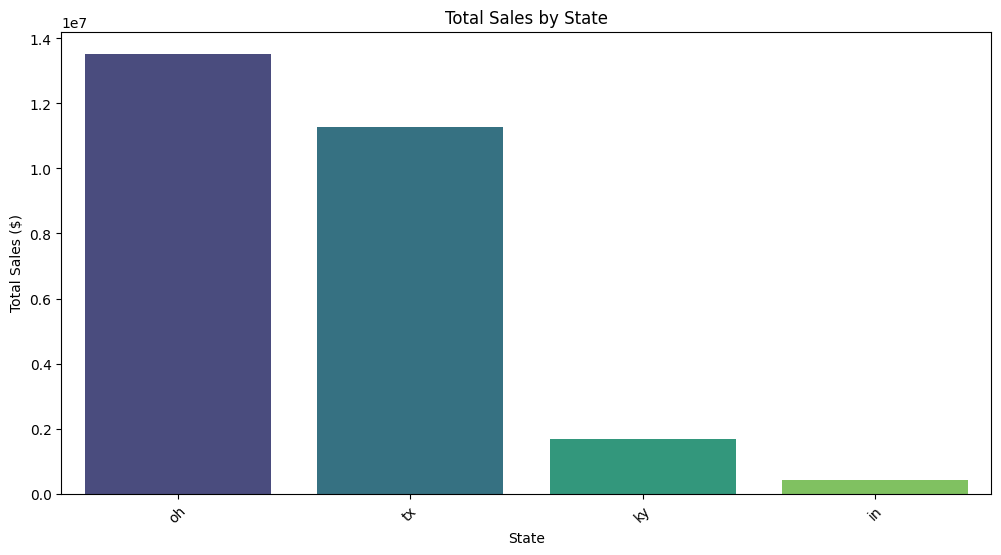

In [326]:
# Group by state and sum the sales (spend)
state_sales = df_final.groupby('state')['spend'].sum().reset_index()

# Sort states by sales for better visualization
state_sales = state_sales.sort_values(by='spend', ascending=False)

# Plot a histogram (bar chart) of sales by state
plt.figure(figsize=(12, 6))
sns.barplot(data=state_sales, x='state', y='spend', palette='viridis')

# Formatting
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.xlabel("State")
plt.ylabel("Total Sales ($)")
plt.title("Total Sales by State")
plt.show()

In [327]:
# Summary statistics
print(df_final[['spend', 'hhs', 'visits', 'price', 'base_price', 'feature', 'display', 'tpr_only']].describe())

               spend            hhs         visits          price  \
count  418555.000000  418555.000000  418555.000000  418555.000000   
mean       64.304869      20.436392      20.926251       3.275747   
std        73.128139      26.141543      26.727241       1.588545   
min         0.000000       1.000000       1.000000       0.000000   
25%        20.930000       6.000000       6.000000       2.200000   
50%        43.350000      13.000000      13.000000       2.920000   
75%        81.200000      25.000000      26.000000       3.630000   
max      2952.000000    1286.000000    1340.000000       8.910000   

          base_price        feature        display       tpr_only  
count  418555.000000  418555.000000  418555.000000  418555.000000  
mean        3.484063       0.093068       0.116981       0.118847  
std         1.690889       0.290528       0.321398       0.323609  
min         0.550000       0.000000       0.000000       0.000000  
25%         2.490000       0.000000   

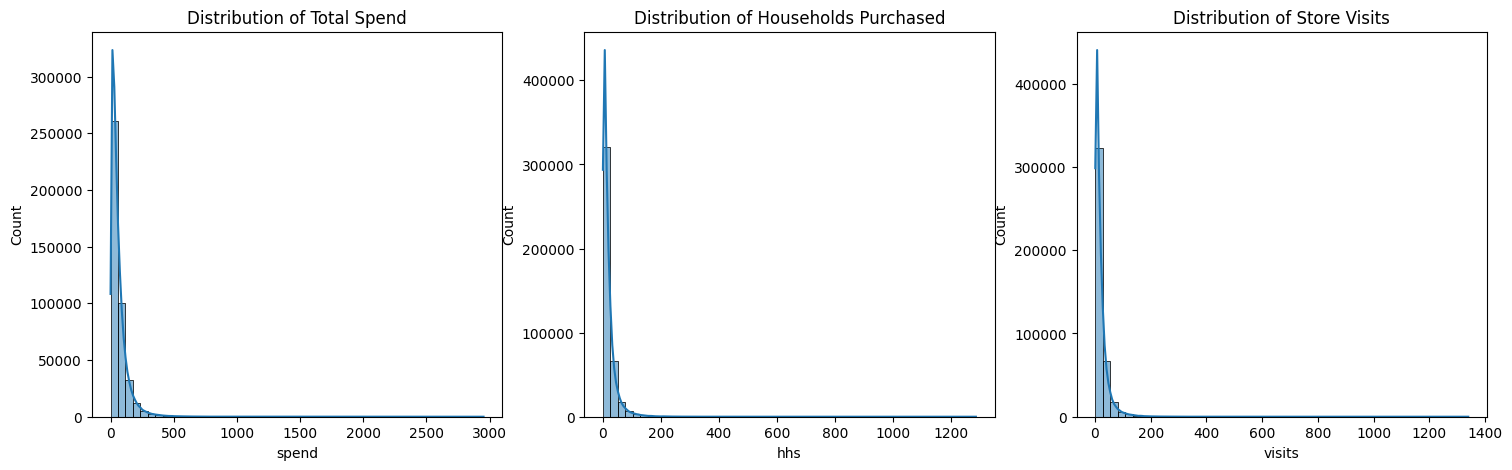

In [328]:
# Histograms of target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_final['spend'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Total Spend")

sns.histplot(df_final['hhs'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Households Purchased")

sns.histplot(df_final['visits'], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of Store Visits")

plt.show()

1. Total Spend: Most transactions involve small purchases, with only a few instances of high spend, many households, or many visits

In [329]:
# Apply log transformation to the data to combat skewness
df_final['log_spend'] = np.log(df_final['spend'] + 1)
df_final['log_hhs'] = np.log(df_final['hhs'] + 1)
df_final['log_visits'] = np.log(df_final['visits'] + 1)

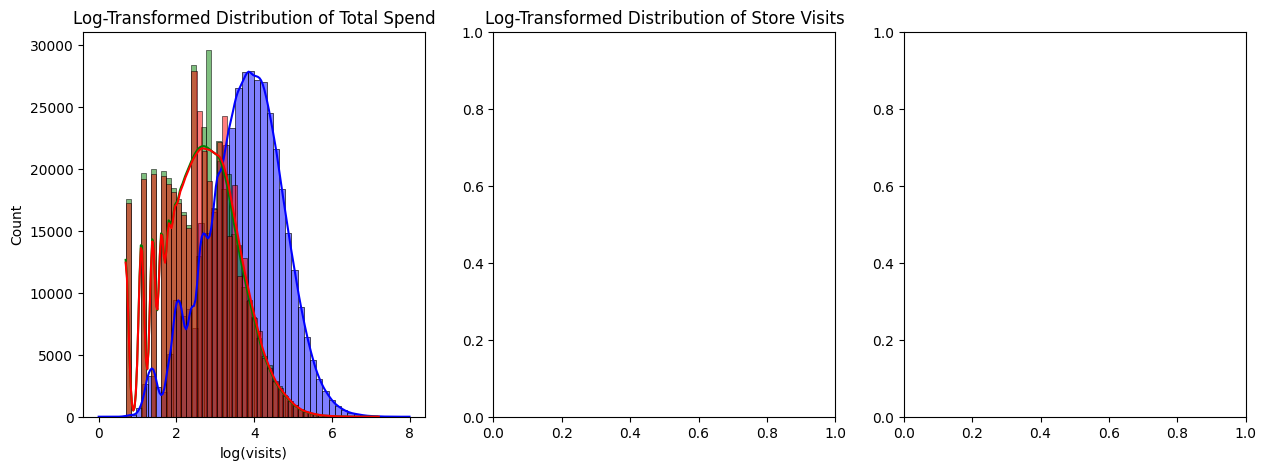

In [330]:
# Apply log transformation to the data
#Set up the figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram for log(spend)
sns.histplot(df_final['log_spend'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Log-Transformed Distribution of Total Spend')
axes[0].set_xlabel('log(spend)')

# Histogram for log(hhs)
sns.histplot(df_final['log_hhs'], bins=50, kde=True, ax=axes[0], color='green')
axes[1].set_title('Log-Transformed Distribution of Households Purchased')
axes[0].set_xlabel('log(visits)')

# Histogram for log(visits)
sns.histplot(df_final['log_visits'], bins=50, kde=True, ax=axes[0], color='red')
axes[1].set_title('Log-Transformed Distribution of Store Visits')
axes[0].set_xlabel('log(visits)')

plt.show()

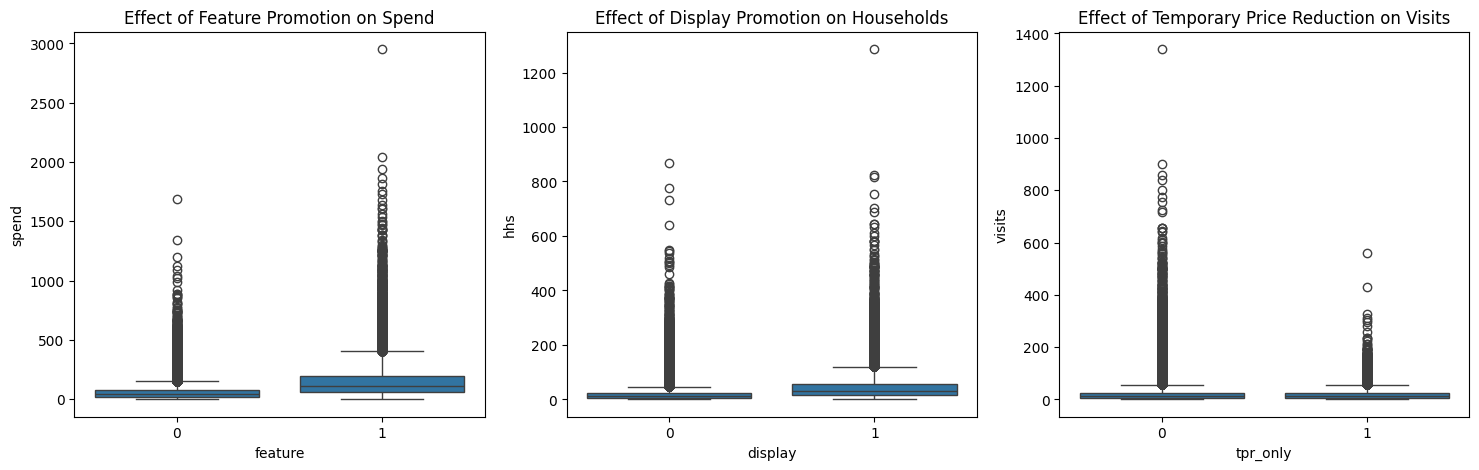

In [331]:
# Boxplots for categorical binary variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=df_final, x='feature', y='spend', ax=axes[0])
axes[0].set_title("Effect of Feature Promotion on Spend")

sns.boxplot(data=df_final, x='display', y='hhs', ax=axes[1])
axes[1].set_title("Effect of Display Promotion on Households")

sns.boxplot(data=df_final, x='tpr_only', y='visits', ax=axes[2])
axes[2].set_title("Effect of Temporary Price Reduction on Visits")

plt.show()

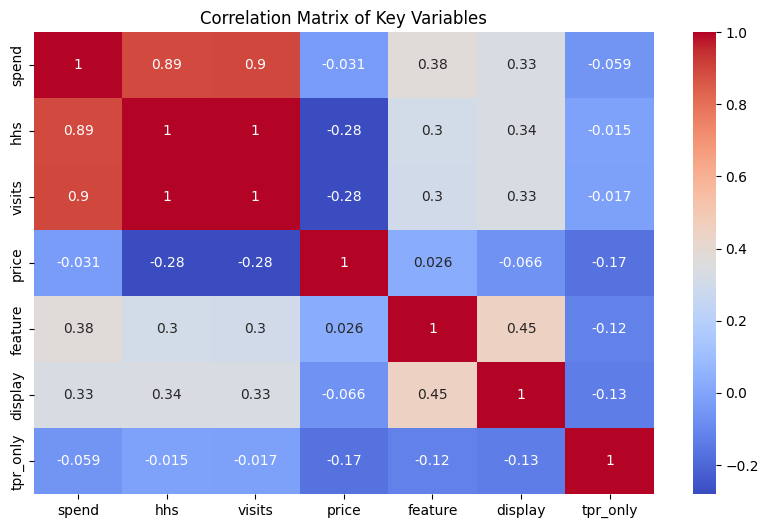

In [332]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df_final[['spend', 'hhs', 'visits', 'price', 'feature', 'display', 'tpr_only']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Key Variables")
plt.show()

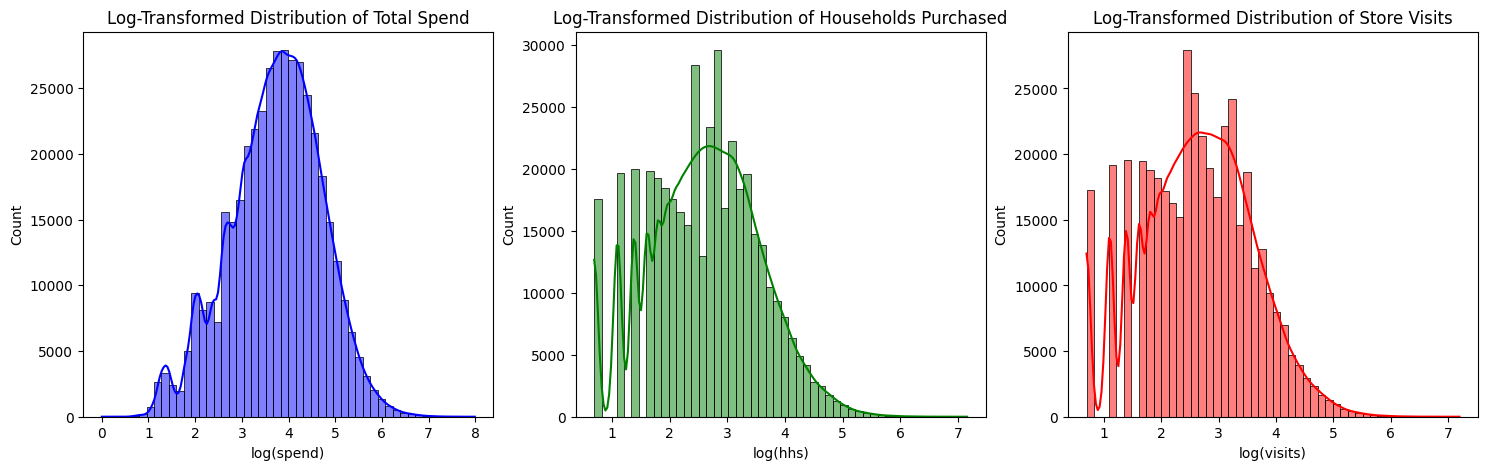

In [333]:
# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for log(spend)
sns.histplot(df_final['log_spend'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Log-Transformed Distribution of Total Spend")
axes[0].set_xlabel("log(spend)")

# Histogram for log(hhs)
sns.histplot(df_final['log_hhs'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title("Log-Transformed Distribution of Households Purchased")
axes[1].set_xlabel("log(hhs)")

# Histogram for log(visits)
sns.histplot(df_final['log_visits'], bins=50, kde=True, ax=axes[2], color='red')
axes[2].set_title("Log-Transformed Distribution of Store Visits")
axes[2].set_xlabel("log(visits)")

# Show the plots
plt.show()

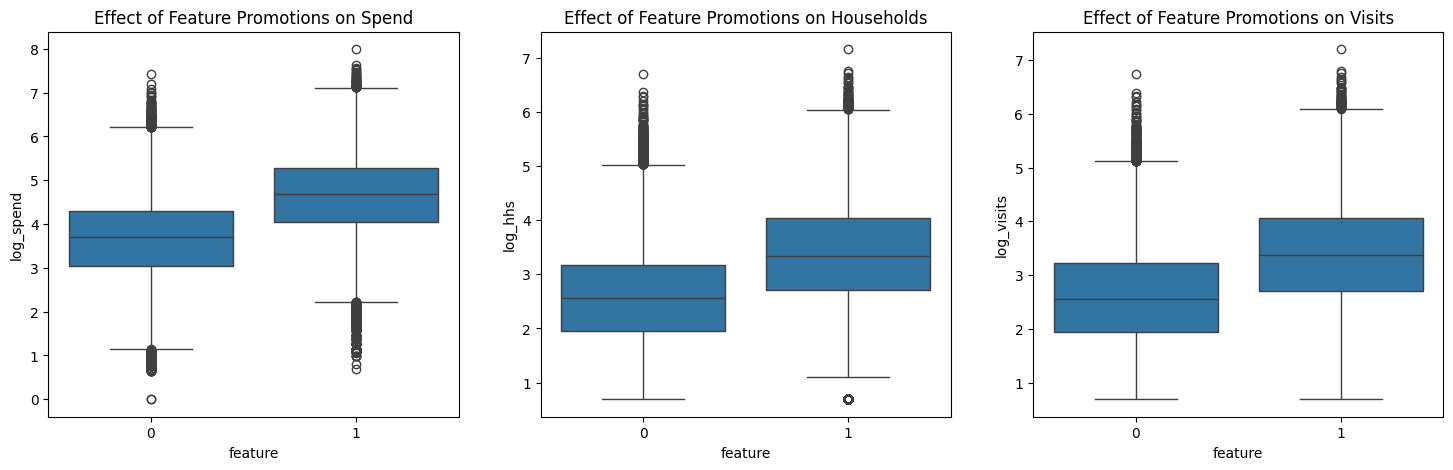

In [334]:
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot for feature promotions
sns.boxplot(data=df_final, x='feature', y='log_spend', ax=axes[0])
axes[0].set_title("Effect of Feature Promotions on Spend")

sns.boxplot(data=df_final, x='feature', y='log_hhs', ax=axes[1])
axes[1].set_title("Effect of Feature Promotions on Households")

sns.boxplot(data=df_final, x='feature', y='log_visits', ax=axes[2])
axes[2].set_title("Effect of Feature Promotions on Visits")

plt.show()

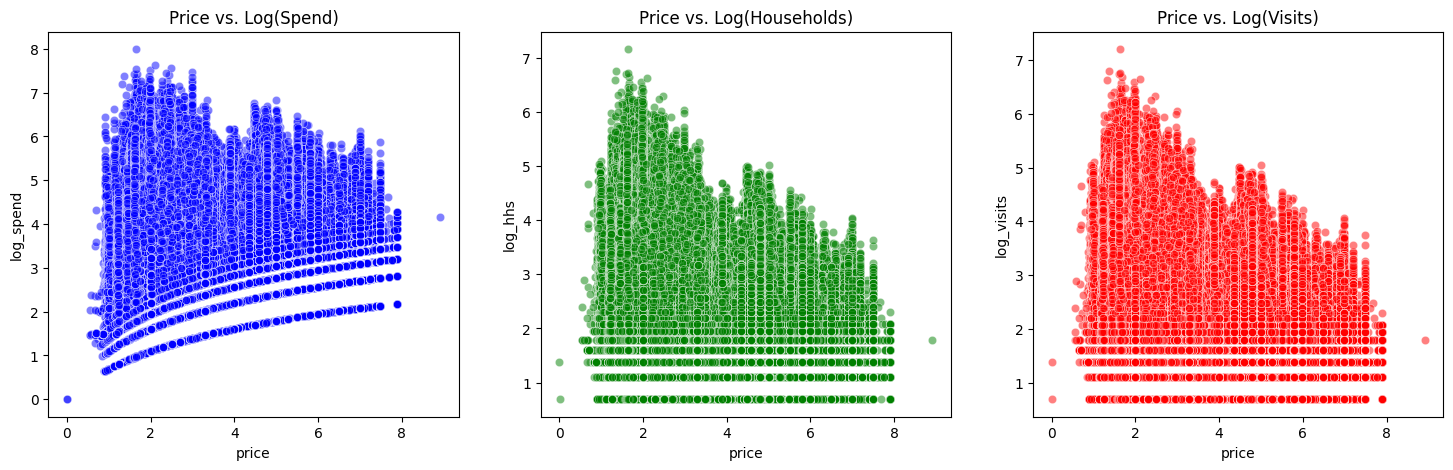

In [335]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_final, x='price', y='log_spend', alpha=0.5, ax=axes[0], color="blue")
axes[0].set_title("Price vs. Log(Spend)")

sns.scatterplot(data=df_final, x='price', y='log_hhs', alpha=0.5, ax=axes[1], color="green")
axes[1].set_title("Price vs. Log(Households)")

sns.scatterplot(data=df_final, x='price', y='log_visits', alpha=0.5, ax=axes[2], color="red")
axes[2].set_title("Price vs. Log(Visits)")

plt.show()

In [336]:
# Define independent variables (predictors)
X = df_final[['price', 'feature', 'display', 'tpr_only']]
X = sm.add_constant(X)  # Add intercept term

# Define dependent variable (log-transformed spend)
y = df_final['log_spend']

# Fit the model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_spend   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                 1.345e+04
Date:                Fri, 28 Feb 2025   Prob (F-statistic):               0.00
Time:                        18:30:31   Log-Likelihood:            -5.5964e+05
No. Observations:              418555   AIC:                         1.119e+06
Df Residuals:                  418550   BIC:                         1.119e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5954      0.004   1016.021      0.0

ValueError: Could not interpret value `store_segment` for `x`. An entry with this name does not appear in `data`.

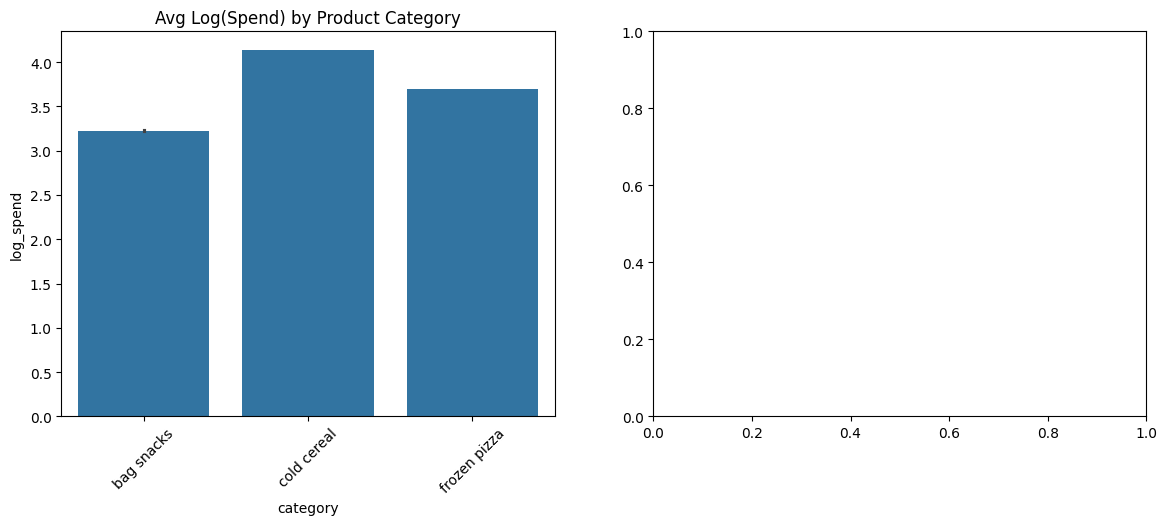

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=df_final, x='category', y='log_spend', estimator=np.mean, ax=axes[0])
axes[0].set_title("Avg Log(Spend) by Product Category")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df_final, x='store_segment', y='log_spend', estimator=np.mean, ax=axes[1])
axes[1].set_title("Avg Log(Spend) by Store Segment")

plt.show()